C:\Users\SEC\AppData\Local\Temp\ipykernel_5880\2557057148.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Close'].fillna(method='ffill', inplace=True)
C:\Users\SEC\AppData\Local\Temp\ipykernel_5880\2557057148.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Close'].fillna(method='ffill', inplace=True)


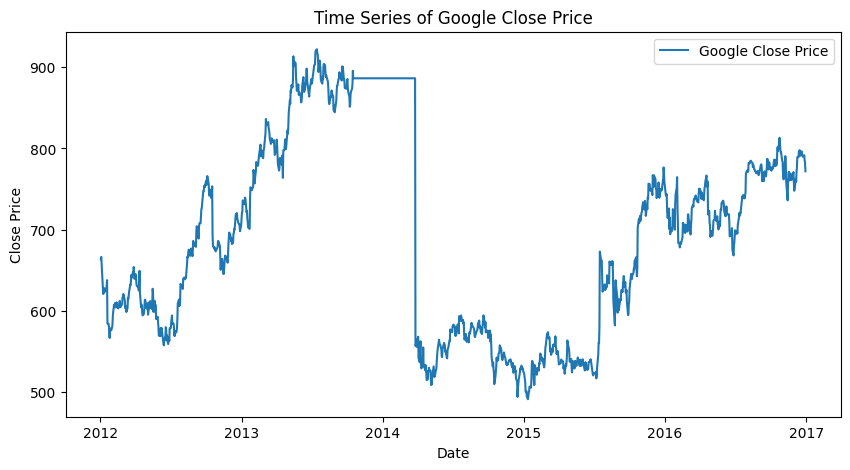

ADF Statistic: -1.8190844290723713
p-value: 0.37102880936170535
Differenced ADF Statistic: -34.69124665990977
Differenced p-value: 0.0


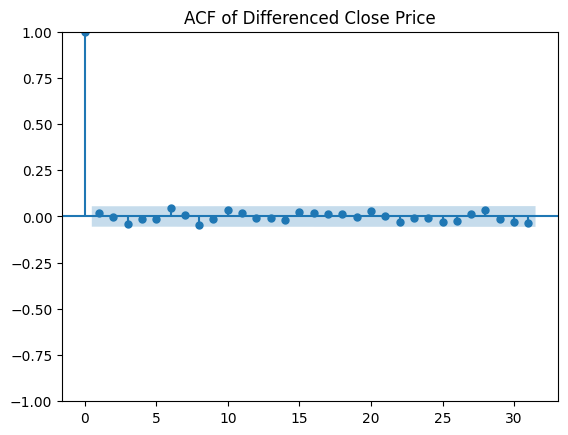

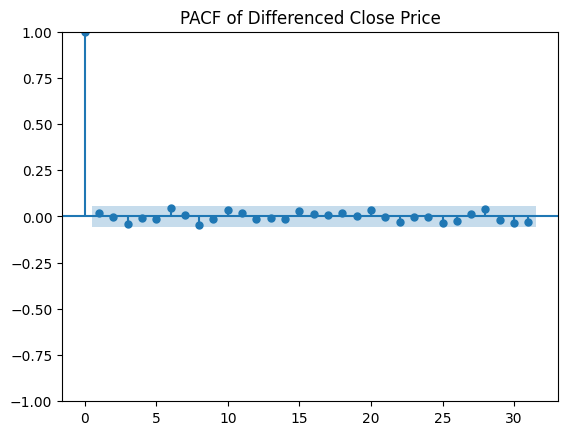

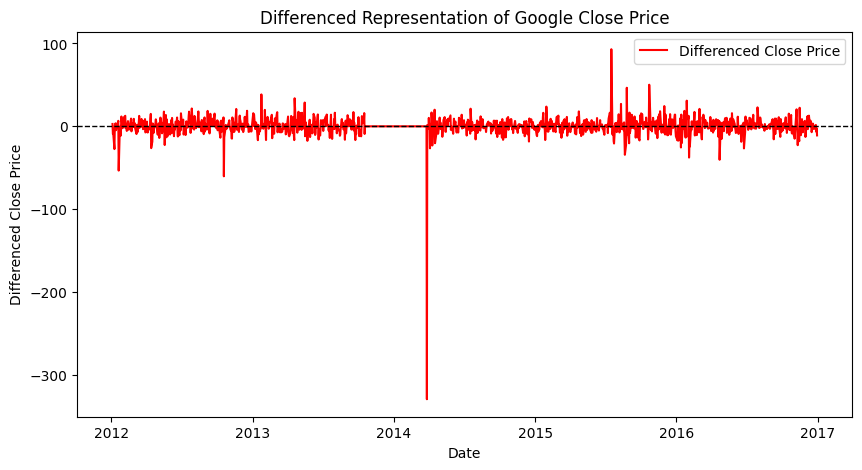

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=10010.884, Time=0.43 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=10007.406, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=10008.890, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=10008.886, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=10005.462, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.697 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1258
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5001.731
Date:                Sat, 26 Oct 2024   AIC                          10005.462
Time:                        22:01:42   BIC                          10010.598
Sample:                             0   HQIC                         10007.392
                               - 1258                                  

C:\Users\SEC\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SEC\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SEC\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\SEC\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an int

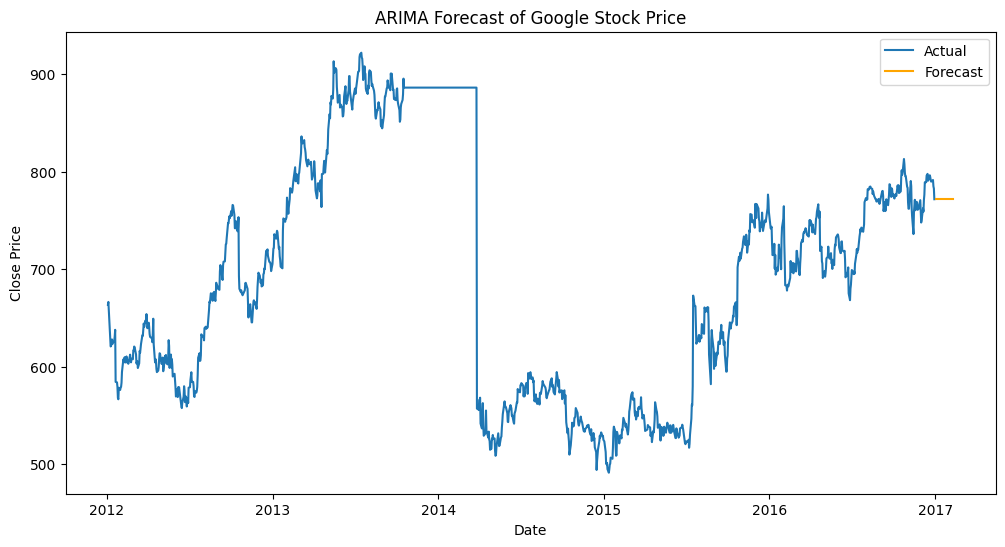

Mean Absolute Error (MAE): 6.783322734499202
Root Mean Squared Error (RMSE): 22.74418731102063


In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
data = pd.read_csv('Google_Stock_Price_Train.csv')
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data.set_index('Date', inplace=True)

# Filter data from 2010 onward
data = data[data.index >= '2010-01-01']

# Convert 'Close' column to numeric and remove missing values
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data['Close'].fillna(method='ffill', inplace=True)

# Plot the Close price to inspect for trends
plt.figure(figsize=(10, 5))
plt.plot(data['Close'], label='Google Close Price')
plt.title('Time Series of Google Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Check stationarity with ADF test
result = adfuller(data['Close'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If p-value > 0.05, apply differencing
data['Close_diff'] = data['Close'].diff().dropna()
result_diff = adfuller(data['Close_diff'].dropna())
print('Differenced ADF Statistic:', result_diff[0])
print('Differenced p-value:', result_diff[1])

# Plot ACF and PACF for differenced data
plot_acf(data['Close_diff'].dropna())
plt.title('ACF of Differenced Close Price')
plt.show()
plot_pacf(data['Close_diff'].dropna())
plt.title('PACF of Differenced Close Price')
plt.show()

# Plot Differenced Representation
plt.figure(figsize=(10, 5))
plt.plot(data['Close_diff'], label='Differenced Close Price', color='red')
plt.title('Differenced Representation of Google Close Price')
plt.xlabel('Date')
plt.ylabel('Differenced Close Price')
plt.axhline(0, color='black', lw=1, linestyle='--')
plt.legend()
plt.show()

# Use auto_arima to find the optimal (p, d, q) parameters
stepwise_model = auto_arima(data['Close'], start_p=1, start_q=1,
                            max_p=3, max_q=3, seasonal=False, trace=True)
p, d, q = stepwise_model.order
print(stepwise_model.summary())

# Fit the ARIMA model using the optimal parameters
model = sm.tsa.ARIMA(data['Close'], order=(p, d, q))
fitted_model = model.fit()
print(fitted_model.summary())

# Forecast the next 30 days
forecast = fitted_model.forecast(steps=30)
forecast_index = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label='Actual')
plt.plot(forecast_index, forecast, label='Forecast', color='orange')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('ARIMA Forecast of Google Stock Price')
plt.legend()
plt.show()

# Evaluate the model with MAE and RMSE
predictions = fitted_model.predict(start=0, end=len(data['Close']) - 1)
mae = mean_absolute_error(data['Close'], predictions)
rmse = np.sqrt(mean_squared_error(data['Close'], predictions))
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
